<a href="https://colab.research.google.com/github/djarnis2/crc-pathmnist-transfer-resnet18/blob/main/Deep_Learning_Assignment2_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
import pandas as pd

# Base-mappe på dit Drive
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/saved_models"

# Undermappe til grid-resultater (så vi roder mindre)
GRID_DIR = os.path.join(BASE_DIR, "pathmnist_grid")
os.makedirs(GRID_DIR, exist_ok=True)

RESULTS_PATH = os.path.join(GRID_DIR, "grid_results_resnet18.csv")
HIST_DIR     = os.path.join(GRID_DIR, "grid_histories")
os.makedirs(HIST_DIR, exist_ok=True)

print("GRID_DIR:", GRID_DIR)
print("RESULTS_PATH:", RESULTS_PATH)
print("HIST_DIR:", HIST_DIR)

# Lav en lille test-CSV og gem den
test_df = pd.DataFrame({"hello": [1, 2, 3]})
test_df.to_csv(RESULTS_PATH, index=False)
print("\nSkrev test-CSV til:", RESULTS_PATH)

# List indholdet
print("\nIndhold i GRID_DIR nu:")
!ls -R "$GRID_DIR"


GRID_DIR: /content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_grid
RESULTS_PATH: /content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_grid/grid_results_resnet18.csv
HIST_DIR: /content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_grid/grid_histories

Skrev test-CSV til: /content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_grid/grid_results_resnet18.csv

Indhold i GRID_DIR nu:
'/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_grid':
grid_histories	grid_results_resnet18.csv  grid_results_resnet18_v2.csv

'/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_grid/grid_histories':
history_resnet18_feature_adamw_lr0.0003.pt
history_resnet18_feature_adamw_lr0.001.pt
history_resnet18_feature_sgd_lr0.003.pt
history_resnet18_feature_sgd_lr0.01.pt
history_resnet18_partial_adamw_lr0.0003.pt
history_resnet18_partial_adamw_lr0.001.pt
history_resnet18_partial_sgd_lr0.003.pt
history_resnet18_partial_sgd_lr0.01.pt


In [10]:
%pip install medmnist
import medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 10.0 MB/s eta 0:00:00


In [11]:
import torchvision.transforms as transforms
from medmnist import PathMNIST, INFO
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

BATCH_SIZE = 64

class PathMNISTDataset(Dataset):

  def __init__(self, split, transform=None, download=True, size: int = 28):
    super().__init__()
    self.info = INFO["pathmnist"]
    self.n_channels = self.info["n_channels"]
    self.base = PathMNIST(
        split=split,
        download=download,
        size=size,
        transform=None, # transforms will be coded later
    )
    self.transform = transform

    label_dict = self.info["label"]
    self.classes = [label_dict[str(i)] for i in  range(len(label_dict))]

  def __len__(self):
    return len(self.base)

  def __getitem__(self, idx):
    img, label = self.base[idx]

    if self.transform is not None:
      img = self.transform(img)

    if hasattr(label, "__len__"):
      label = int(label[0])
    else:
      label = int(label)

    label = torch.tensor(label, dtype=torch.long)

    return img, label


In [12]:
class PathMNISTDataModule:
  def __init__(self, batch_size: int = BATCH_SIZE, size: int = 28):
    self.info = INFO["pathmnist"]
    self.n_channels = self.info["n_channels"]
    self.n_classes = len(self.info["label"])
    self.batch_size = batch_size
    self.size = size

    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]

    self.data_transforms = {
        "train": transforms.Compose([
            transforms.Resize(224),
            transforms.RandomHorizontalFlip(p=0.5),
            #transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(imagenet_mean, imagenet_std),
            ]),
        "val": transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(imagenet_mean, imagenet_std),
            ]),
        "test": transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(imagenet_mean, imagenet_std),
            ]),
    }

    self.datasets = {
        "train": PathMNISTDataset(
            split="train",
            transform=self.data_transforms['train'],
            size=self.size,
            ),
        "val": PathMNISTDataset(
            split="val",
            transform=self.data_transforms['val'],
            size=self.size,
            ),
        "test": PathMNISTDataset(
            split="test",
            transform=self.data_transforms['test'],
            size=self.size,
            ),
        }

    self.train_loader = DataLoader(
        self.datasets["train"],
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=2,
    )
    self.val_loader = DataLoader(
        self.datasets["val"],
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=2,
    )
    self.test_loader = DataLoader(
        self.datasets["test"],
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2,
    )

  @property
  def class_names(self):
      return self.datasets["train"].classes

  def dataset_sizes(self):
      return {split: len(self.datasets[split]) for split in ["train", "val"]}

  def print_info(self):
      print("task:", self.info["task"])
      print("n_channels:", self.n_channels)
      print("n_classes:", self.n_classes)
      for split in ["train", "val", "test"]:
          print(f"{split} size:", len(self.datasets[split]))

def visualize_raw_data(self, samples_per_class: int = 3):
    """
    Visualiser rå (u-normaliserede) billeder direkte fra MedMNIST.
    Viser 'samples_per_class' patches pr. klasse.
    """
    train_base = self.datasets["train"].base  # medmnist.PathMNIST
    imgs = train_base.imgs                    # (N, 28, 28, 3)
    labels = train_base.labels.flatten()
    label_dict = self.info["label"]

    n_rows = self.n_classes
    n_cols = samples_per_class

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(n_cols * 2.0, n_rows * 2.0),  # mindre figur
    )

    # axes er 1D hvis n_cols == 1 → gør det altid 2D
    if n_cols == 1:
        axes = np.expand_dims(axes, axis=1)

    for class_idx in range(n_rows):
        class_indices = np.where(labels == class_idx)[0][:samples_per_class]
        for j in range(n_cols):
            ax = axes[class_idx, j]
            if j < len(class_indices):
                img = imgs[class_indices[j]]
                ax.imshow(img)
                ax.set_title(
                    f"{class_idx}: {label_dict[str(class_idx)]}",
                    fontsize=8,
                )
            ax.axis("off")

    plt.tight_layout()
    plt.show()


In [13]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_raw_data_landscape(data_module, samples_per_class: int = 3):
    """Vis rå PathMNIST-patches i et bredt (landscape) grid."""


    train_base = data_module.datasets["train"].base
    imgs = train_base.imgs
    labels = train_base.labels.flatten()
    label_dict = data_module.info["label"]

    n_classes = data_module.n_classes
    n_rows = samples_per_class      # rækker = samples per class
    n_cols = n_classes              # kolonner = klasser

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(n_cols * 1.8, n_rows * 1.8),  # bredere end højt
    )

    # hvis kun én række
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for class_idx in range(n_classes):
        class_indices = np.where(labels == class_idx)[0][:samples_per_class]

        for j in range(n_rows):
            ax = axes[j, class_idx]
            if j < len(class_indices):
                img = imgs[class_indices[j]]
                ax.imshow(img)
                # kun titel på øverste række, ellers bliver det rodet
                if j == 0:
                    ax.set_title(
                        f"{class_idx}: {label_dict[str(class_idx)]}",
                        fontsize=8,
                    )
            ax.axis("off")

    plt.tight_layout()
    plt.show()


In [15]:
data_module = PathMNISTDataModule(batch_size=64)
train_loader = data_module.train_loader
val_loader = data_module.val_loader
test_loader = data_module.test_loader
class_names = data_module.class_names

# tag første batch fra train_loader
train_images, train_labels = next(iter(train_loader))
val_images, val_labels = next(iter(val_loader))

print("Train batch images shape:", train_images.shape)   # fx: torch.Size([64, 3, 224, 224])
print("Train batch labels shape:", train_labels.shape)   # fx: torch.Size([64])

print("Val batch images shape:", val_images.shape)
print("Val batch labels shape:", val_labels.shape)

print("Class names:", class_names)


100%|██████████| 206M/206M [05:33<00:00, 616kB/s]


Train batch images shape: torch.Size([64, 3, 224, 224])
Train batch labels shape: torch.Size([64])
Val batch images shape: torch.Size([64, 3, 224, 224])
Val batch labels shape: torch.Size([64])
Class names: ['adipose', 'background', 'debris', 'lymphocytes', 'mucus', 'smooth muscle', 'normal colon mucosa', 'cancer-associated stroma', 'colorectal adenocarcinoma epithelium']


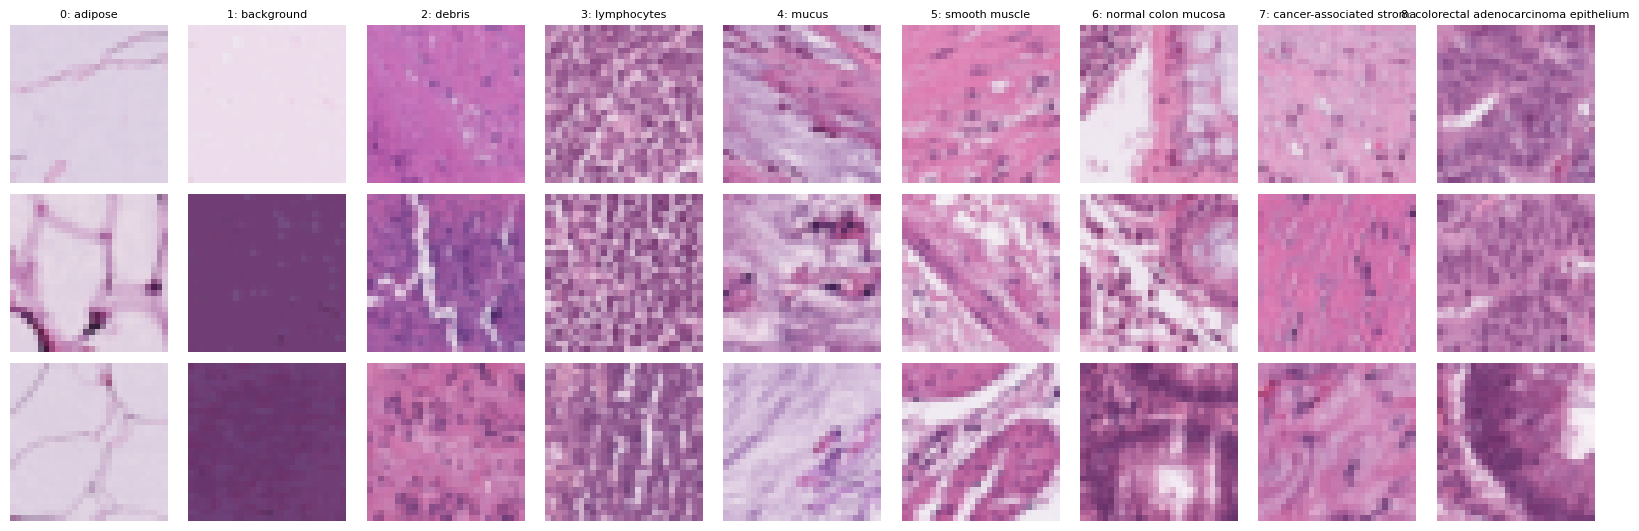

In [10]:
visualize_raw_data_landscape(data_module, samples_per_class=3)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_class_counts(data_module, split="train"):
    """
    Plot antal samples pr. klasse for et givet split ('train', 'val', 'test')
    """
    base = data_module.datasets[split].base   # medmnist base-dataset
    labels = base.labels.flatten()
    label_dict = data_module.info["label"]

    class_ids = np.arange(data_module.n_classes)
    counts = [np.sum(labels == i) for i in class_ids]
    names = [label_dict[str(i)] for i in class_ids]

    plt.figure(figsize=(8, 4))
    plt.bar(class_ids, counts)
    plt.xticks(class_ids, names, rotation=45, ha="right", fontsize=8)
    plt.ylabel("Number of samples")
    plt.title(f"Class distribution in {split} set")
    plt.tight_layout()
    plt.show()

    # hvis du vil gemme til LaTeX:
    # plt.savefig("pathmnist_class_counts_train.png", dpi=300, bbox_inches="tight")


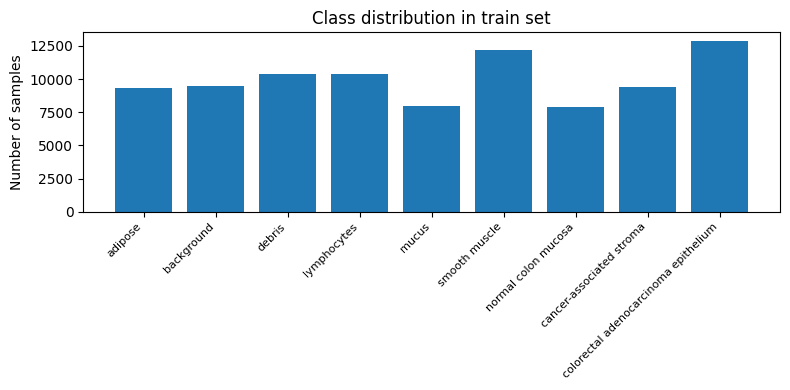

In [12]:
plot_class_counts(data_module)

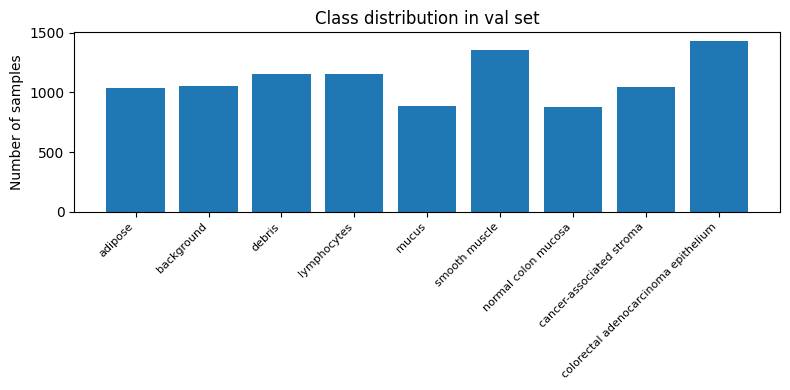

In [14]:
plot_class_counts(data_module, split="val")

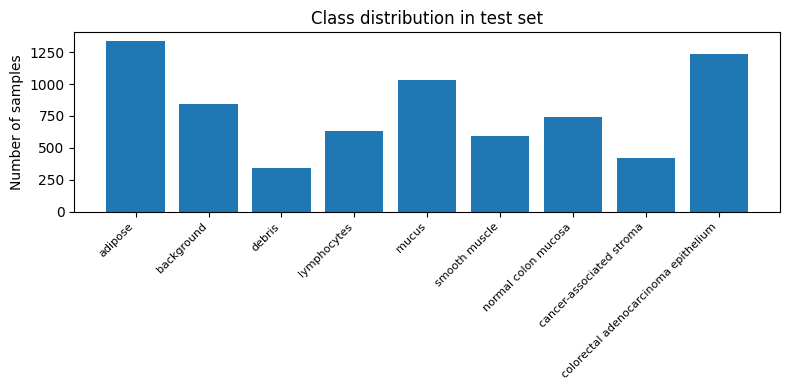

In [13]:
plot_class_counts(data_module, split="test")

In [15]:
def plot_class_counts_all(data_module):
    label_dict = data_module.info["label"]
    class_ids = np.arange(data_module.n_classes)

    all_labels = []
    for split in ["train", "val", "test"]:
        base = data_module.datasets[split].base
        all_labels.append(base.labels.flatten())
    all_labels = np.concatenate(all_labels)

    counts = [np.sum(all_labels == i) for i in class_ids]
    names = [label_dict[str(i)] for i in class_ids]

    plt.figure(figsize=(8, 4))
    plt.bar(class_ids, counts)
    plt.xticks(class_ids, names, rotation=45, ha="right", fontsize=8)
    plt.ylabel("Number of samples")
    plt.title("Class distribution (train + val + test)")
    plt.tight_layout()
    plt.show()


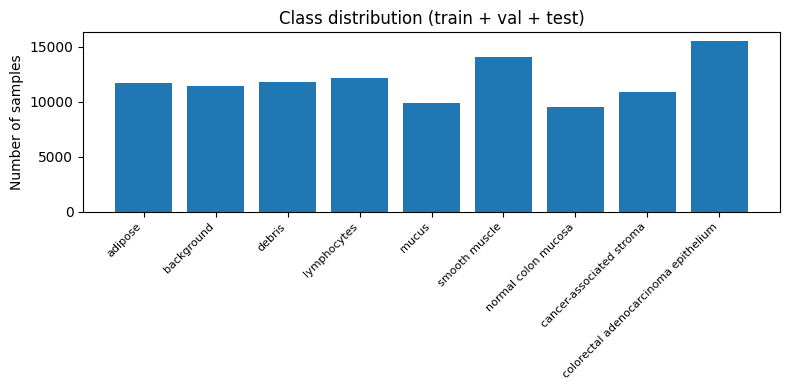

In [16]:
plot_class_counts_all(data_module)

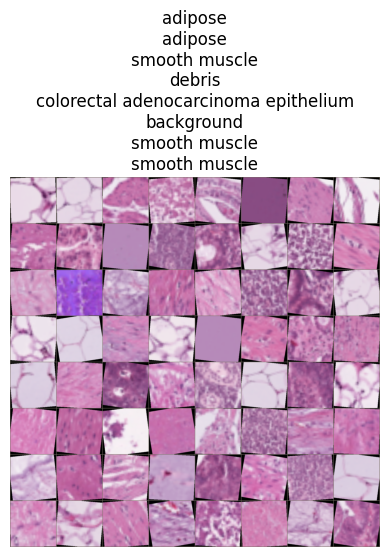

In [9]:
import torchvision
inputs, labels = next(iter(train_loader))

# lav en grid
out = torchvision.utils.make_grid(inputs)

def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean      # unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis("off")
    plt.show()

titles = [class_names[x.item()] for x in labels]
imshow(out, title="\n".join(titles[:8]))


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

def train_model(model, criterion, optimizer, scheduler,
                dataloaders, dataset_sizes, device,
                num_epochs=25, patience=5, monitor="val_acc"):
    since = time.time()

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "val_auc": [],
        "val_f1": [],
        "val_f1_cancer": [],
    }

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_score = -float("inf")
        epochs_no_improve = 0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                all_labels = []
                all_probs = []
                all_preds = []

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    if phase == "val":
                        probs = torch.softmax(outputs, dim=1) # [batch, n_classes]
                        all_probs.append(probs.detach().cpu().numpy())
                        all_labels.append(labels.detach().cpu().numpy())
                        all_preds.append(preds.detach().cpu().numpy())

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == "train":
                    history["train_loss"].append(epoch_loss)
                    history["train_acc"].append(epoch_acc.item())
                    print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
                else:
                    if len(all_labels) > 0:
                        y_true = np.concatenate(all_labels) # shape [N]
                        y_score = np.concatenate(all_probs) # shape [N, n_classses]
                        y_pred = np.concatenate(all_preds)

                        try:
                            epoch_auc = roc_auc_score(
                                y_true, y_score,
                                multi_class="ovr",
                                average="macro",
                            )
                        except ValueError:
                            epoch_auc = float("nan")

                        epoch_f1 = f1_score(y_true, y_pred, average="macro")
                        is_cancer_true = (y_true == 8).astype(int)
                        is_cancer_pred = (y_pred == 8).astype(np.int_)

                        epoch_f1_cancer = f1_score(is_cancer_true, is_cancer_pred, average="binary")


                    else:
                        epoch_auc = float("nan")
                        epoch_f1 = float("nan")

                    history["val_loss"].append(epoch_loss)
                    history["val_acc"].append(epoch_acc.item())
                    history["val_auc"].append(epoch_auc)
                    history["val_f1"].append(epoch_f1)
                    history["val_f1_cancer"].append(epoch_f1_cancer)

                    print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC: {epoch_auc:.4f} F1(macro): {epoch_f1:.4f} F1(cancer): {epoch_f1_cancer:.4f}")

                    if monitor == "val_acc":
                        score = epoch_acc.item()
                    elif monitor == "val_auc":
                        score = epoch_auc
                    elif monitor == "val_f1":
                        score = epoch_f1
                    elif monitor == "val_f1_cancer":
                        score = epoch_f1_cancer
                    else:
                        raise ValueError(f"Unknown monitor metric: {monitor}")


                    # deep copy the model
                    if score > best_score:
                        best_score = score
                        torch.save(model.state_dict(), best_model_params_path)
                        epochs_no_improve = 0
                    else:
                        epochs_no_improve += 1

            # check early stopping
            if epochs_no_improve >= patience:
                print(f"No improvement for {patience} epochs, stopping early.")
                break

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best {monitor}: {best_score:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    return model, history

In [ ]:
# GRID SEARCH

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
import pandas as pd

# =====================================================================
# Paths til Drive
# =====================================================================
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/saved_models"
GRID_DIR = os.path.join(BASE_DIR, "pathmnist_grid")
os.makedirs(GRID_DIR, exist_ok=True)

RESULTS_PATH = os.path.join(GRID_DIR, "grid_results_resnet18_v2.csv")
HIST_DIR     = os.path.join(GRID_DIR, "grid_histories")
os.makedirs(HIST_DIR, exist_ok=True)

print("Gemmer resultater i:", GRID_DIR)

# =====================================================================
# Dataloaders + dataset sizes (forudsætter at de findes i forvejen)
# =====================================================================
dataloaders = {
    "train": train_loader,
    "val":   val_loader,
}
dataset_sizes = {
    "train": len(data_module.datasets["train"]),
    "val":   len(data_module.datasets["val"]),
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_classes = len(class_names)

criterion = nn.CrossEntropyLoss()

# =====================================================================
# Helpers: model, optimizer, scheduler
# =====================================================================
def create_resnet18(finetune_mode: str = "partial") -> nn.Module:
    """
    finetune_mode:
      - 'feature' : frys hele backbone, træn kun fc
      - 'partial' : frys layer1-3, træn layer4 + fc
      - 'full'    : træn alle lag (bruger vi ikke i denne grid)
    """
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, n_classes)

    if finetune_mode == "feature":
        for p in model.parameters():
            p.requires_grad = False
        for p in model.fc.parameters():
            p.requires_grad = True

    elif finetune_mode == "partial":
        for name, p in model.named_parameters():
            p.requires_grad = False
            if name.startswith("layer4") or name.startswith("fc"):
                p.requires_grad = True

    elif finetune_mode == "full":
        for p in model.parameters():
            p.requires_grad = True
    else:
        raise ValueError(f"Unknown finetune_mode: {finetune_mode}")

    return model.to(device)


def create_optimizer(optimizer_name: str, model: nn.Module, lr: float, weight_decay: float = 1e-4):
    params = [p for p in model.parameters() if p.requires_grad]
    opt = optimizer_name.lower()
    if opt == "sgd":
        return optim.SGD(params, lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif opt == "adamw":
        return optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")


def create_scheduler(optimizer, scheduler_name: str = "steplr"):
    name = scheduler_name.lower()
    if name == "steplr":
        return optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    else:
        raise ValueError(f"Unknown scheduler: {scheduler_name}")


# =====================================================================
# Grid-definition
# =====================================================================
finetune_modes = ["feature", "partial"]
optimizers = ["sgd", "adamw"]

# We set slightly higher lr for sgd
# because this optimizer typically needs higher lrs
sgd_lrs   = [1e-2, 3e-3]
adamw_lrs = [1e-3, 3e-4]

# =====================================================================
# Load tidligere resultater hvis de findes
# =====================================================================
if os.path.exists(RESULTS_PATH):
    df_results = pd.read_csv(RESULTS_PATH)
    done_configs = set(df_results["config"].tolist())
    print(f"Loaded {len(df_results)} existing results.")
else:
    df_results = pd.DataFrame()
    done_configs = set()
    print("No existing results found, starting fresh.")

# =====================================================================
# Kør / fortsæt grid-search
# =====================================================================
for finetune_mode in finetune_modes:
    for opt_name in optimizers:
        lr_list = sgd_lrs if opt_name == "sgd" else adamw_lrs

        for lr in lr_list:
            config_name = f"resnet18_{finetune_mode}_{opt_name}_lr{lr}"

            # Skip hvis allerede kørt og gemt
            if config_name in done_configs:
                print(f"\nSkipping already completed config: {config_name}")
                continue

            print("\n" + "=" * 80)
            print(f"Running config: {config_name}")
            print("=" * 80)

            # 1) Model / optimizer / scheduler
            model = create_resnet18(finetune_mode=finetune_mode)
            optimizer = create_optimizer(opt_name, model, lr=lr)
            scheduler = create_scheduler(optimizer, "steplr")

            # 2) Træning (kort screening)
            model_trained, history = train_model(
                model=model,
                criterion=criterion,
                optimizer=optimizer,
                scheduler=scheduler,
                dataloaders=dataloaders,
                dataset_sizes=dataset_sizes,
                device=device,
                num_epochs=5,       # du har sat 5 her – fint til screening
                patience=3,
                monitor="val_f1",   # eller "val_f1_cancer"
            )

            # 3) Metrics for denne config
            best_val_acc = max(history["val_acc"]) if history["val_acc"] else float("nan")
            best_val_auc = max([x for x in history["val_auc"] if not np.isnan(x)]) if history["val_auc"] else float("nan")
            best_val_f1  = max(history["val_f1"]) if history["val_f1"] else float("nan")
            best_val_f1_cancer = (
                max(history.get("val_f1_cancer", [float("nan")]))
                if history.get("val_f1_cancer") else float("nan")
            )

            row = {
                "config": config_name,
                "finetune_mode": finetune_mode,
                "optimizer": opt_name,
                "lr": lr,
                "best_val_acc": best_val_acc,
                "best_val_auc": best_val_auc,
                "best_val_f1": best_val_f1,
                "best_val_f1_cancer": best_val_f1_cancer,
            }

            # 4) Append til df_results og GEM til Drive med det samme
            df_results = pd.concat([df_results, pd.DataFrame([row])], ignore_index=True)
            df_results.to_csv(RESULTS_PATH, index=False)
            done_configs.add(config_name)

            # 5) Gem history separat (til plots/analyse senere)
            hist_path = os.path.join(HIST_DIR, f"history_{config_name}.pt")
            torch.save(history, hist_path)

# =====================================================================
# Sorterede resultater til sidst
# =====================================================================
if "best_val_f1_cancer" in df_results.columns and df_results["best_val_f1_cancer"].notna().any():
    sort_key = "best_val_f1_cancer"
else:
    sort_key = "best_val_f1"

df_results_sorted = df_results.sort_values(by=sort_key, ascending=False)

print("\nGrid search results (sorted by", sort_key, "):")
print(df_results_sorted)


Gemmer resultater i: /content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_grid
No existing results found, starting fresh.

Running config: resnet18_feature_sgd_lr0.01
Epoch 0/4
----------
train Loss: 0.5233 Acc: 0.8163
val Loss: 0.3889 Acc: 0.8668 AUC: 0.9881 F1(macro): 0.8641 F1(cancer): 0.8547

Epoch 1/4
----------
train Loss: 0.4409 Acc: 0.8450
val Loss: 0.3966 Acc: 0.8629 AUC: 0.9891 F1(macro): 0.8583 F1(cancer): 0.8656

Epoch 2/4
----------
train Loss: 0.4301 Acc: 0.8483
val Loss: 0.3635 Acc: 0.8767 AUC: 0.9897 F1(macro): 0.8743 F1(cancer): 0.8665

Epoch 3/4
----------
train Loss: 0.4295 Acc: 0.8497
val Loss: 0.3856 Acc: 0.8623 AUC: 0.9892 F1(macro): 0.8660 F1(cancer): 0.8750

Epoch 4/4
----------
train Loss: 0.4253 Acc: 0.8497
val Loss: 0.3778 Acc: 0.8634 AUC: 0.9898 F1(macro): 0.8666 F1(cancer): 0.8618

Training complete in 17m 20s
Best val_f1: 0.874321

Running config: resnet18_feature_sgd_lr0.003
Epoch 0/4
----------
train Loss: 0.5694 Acc: 0.8081
val Loss: 0.3944 Acc

In [ ]:
# For the real training once the right parameteres are found

In [ ]:
# *** Model med fuld træning lr = 0.001 ***

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler

dataloaders = {
    'train': train_loader,
    'val': val_loader,
}
dataset_sizes = {
    'train': len(data_module.datasets['train']),
    'val': len(data_module.datasets['val'])
}

num_classes = len(data_module.class_names)

model_full = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

num_ftrs = model_full.fc.in_features

model_full.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_full = model_full.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_full.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_full, history_full = train_model(
    model=model_full,
    criterion=criterion,
    optimizer=optimizer_ft,
    scheduler=exp_lr_scheduler,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    device=device,
    num_epochs=25,
    patience=25,
    monitor="val_f1_cancer",
)


Epoch 0/24
----------
train Loss: 0.2649 Acc: 0.9128
val Loss: 0.0969 Acc: 0.9672 AUC: 0.9992 F1(macro): 0.9673 F1(cancer): 0.9743

Epoch 1/24
----------
train Loss: 0.1014 Acc: 0.9660
val Loss: 0.0656 Acc: 0.9775 AUC: 0.9995 F1(macro): 0.9773 F1(cancer): 0.9735

Epoch 2/24
----------
train Loss: 0.0731 Acc: 0.9756
val Loss: 0.0486 Acc: 0.9851 AUC: 0.9997 F1(macro): 0.9851 F1(cancer): 0.9826

Epoch 3/24
----------
train Loss: 0.0583 Acc: 0.9806
val Loss: 0.0346 Acc: 0.9892 AUC: 0.9998 F1(macro): 0.9890 F1(cancer): 0.9866

Epoch 4/24
----------
train Loss: 0.0449 Acc: 0.9851
val Loss: 0.0305 Acc: 0.9900 AUC: 0.9998 F1(macro): 0.9898 F1(cancer): 0.9888

Epoch 5/24
----------
train Loss: 0.0388 Acc: 0.9872
val Loss: 0.0271 Acc: 0.9910 AUC: 0.9999 F1(macro): 0.9909 F1(cancer): 0.9895

Epoch 6/24
----------
train Loss: 0.0319 Acc: 0.9893
val Loss: 0.0303 Acc: 0.9909 AUC: 0.9999 F1(macro): 0.9909 F1(cancer): 0.9903

Epoch 7/24
----------
train Loss: 0.0235 Acc: 0.9922
val Loss: 0.0198 Acc: 0

In [ ]:
# SKIFT NAVN PÅ FIL FOR IKKE AT OVERSKRIVE; HVIS DU SKAL GEMME NY MODEL

#save_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_full_sgd_lr0.001.pt"
#torch.save(model_full.state_dict(), save_path)
#print("Model saved to:", save_path)

#hist_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_full_sgd_lr0.001_history.pt"
#torch.save(history_full, hist_path)
#print("History saved to:", hist_path)

Model saved to: /content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_full_sgd_lr0.001.pt
History saved to: /content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_full_sgd_lr0.001_history.pt


In [ ]:
# For at loade den ovenstående model (pathmnist_resnet18_full_sgd_lr0.001):
import torch

load_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_full_sgd_lr0.001.pt"

model_full = models.resnet18(weights=None)
model_full.fc = nn.Linear(model_full.fc.in_features, num_classes)
model_full.load_state_dict(torch.load(load_path, weights_only=True))

history_full = torch.load(hist_path, weights_only=False)

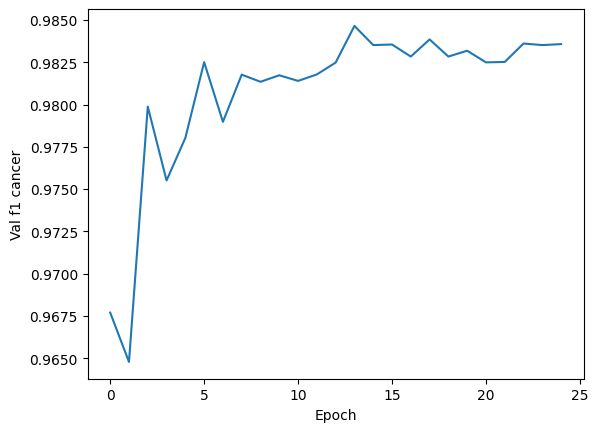

In [ ]:
# Eller printe fra mappen
import torch

HIST_PATH  = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_partial_sgd_lr0.01_history.pt"
history_full = torch.load(HIST_PATH, weights_only=False)

# f.eks. plot val_loss
import matplotlib.pyplot as plt

plt.plot(history_full["val_f1_cancer"])
plt.xlabel("Epoch")
plt.ylabel("Val f1 cancer")
plt.show()


In [ ]:
# *** Anden Model med fuld træning lr = 0.01 ***

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler

dataloaders = {
    'train': train_loader,
    'val': val_loader,
}
dataset_sizes = {
    'train': len(data_module.datasets['train']),
    'val': len(data_module.datasets['val'])
}

num_classes = len(data_module.class_names)

model_full_high_lr = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

num_ftrs = model_full_high_lr.fc.in_features

model_full_high_lr.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_full_high_lr = model_full_high_lr.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_full_high_lr.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_full_high_lr, history_full_high_lr = train_model(
    model=model_full_high_lr,
    criterion=criterion,
    optimizer=optimizer_ft,
    scheduler=exp_lr_scheduler,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    device=device,
    num_epochs=25,
    patience=5,
    monitor="val_f1_cancer",
)


Epoch 0/24
----------
train Loss: 0.1824 Acc: 0.9388
val Loss: 0.0997 Acc: 0.9664 AUC: 0.9992 F1(macro): 0.9666 F1(cancer): 0.9756

Epoch 1/24
----------
train Loss: 0.0704 Acc: 0.9763
val Loss: 0.0416 Acc: 0.9864 AUC: 0.9998 F1(macro): 0.9861 F1(cancer): 0.9822

Epoch 2/24
----------
train Loss: 0.0517 Acc: 0.9827
val Loss: 0.0349 Acc: 0.9895 AUC: 0.9998 F1(macro): 0.9895 F1(cancer): 0.9850

Epoch 3/24
----------
train Loss: 0.0359 Acc: 0.9877
val Loss: 0.0324 Acc: 0.9896 AUC: 0.9999 F1(macro): 0.9896 F1(cancer): 0.9881

Epoch 4/24
----------
train Loss: 0.0303 Acc: 0.9894
val Loss: 0.0242 Acc: 0.9913 AUC: 0.9999 F1(macro): 0.9913 F1(cancer): 0.9899

Epoch 5/24
----------
train Loss: 0.0244 Acc: 0.9918
val Loss: 0.0480 Acc: 0.9849 AUC: 0.9999 F1(macro): 0.9850 F1(cancer): 0.9789

Epoch 6/24
----------
train Loss: 0.0236 Acc: 0.9923
val Loss: 0.0265 Acc: 0.9909 AUC: 0.9999 F1(macro): 0.9909 F1(cancer): 0.9864

Epoch 7/24
----------
train Loss: 0.0083 Acc: 0.9973
val Loss: 0.0118 Acc: 0

In [ ]:
# SKIFT NAVN PÅ FIL FOR IKKE AT OVERSKRIVE; HVIS DU SKAL GEMME NY MODEL

#save_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_full_sgd_high_lr.pt"
#torch.save(model_full_high_lr.state_dict(), save_path)
#print("Model saved to:", save_path)

#hist_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_full_sgd_high_lr_history.pt"
#torch.save(history_full_high_lr, hist_path)
#print("History saved to:", hist_path)

Model saved to: /content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_full_sgd_high_lr.pt
History saved to: /content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_full_sgd_high_lr_history.pt


In [ ]:
# For at loade den ovenstående model (pathmnist_resnet18_full_sgd_high_lr):
import torch

load_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_full_sgd_high_lr.pt"

model_full_high_lr = models.resnet18(weights=None)
model_full_high_lr.fc = nn.Linear(model_full_high_lr.fc.in_features, num_classes)
model_full_high_lr.load_state_dict(torch.load(load_path, weights_only=True))

history_full_high_lr = torch.load(hist_path, weights_only=False)

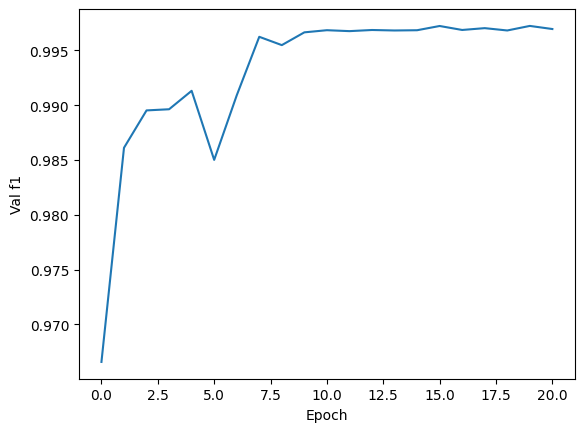

In [ ]:
# Eller printe fra mappen
import torch

HIST_PATH  = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_full_sgd_high_lr_history.pt"
history_full_high_lr = torch.load(HIST_PATH, weights_only=False)

# f.eks. plot val_loss
import matplotlib.pyplot as plt

plt.plot(history_full_high_lr["val_f1"])
plt.xlabel("Epoch")
plt.ylabel("Val f1")
plt.show()


In [ ]:
# *** Model fra grid search med layer 4, SGD og lr 0.01 ***

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler

dataloaders = {
    'train': train_loader,
    'val': val_loader,
}
dataset_sizes = {
    'train': len(data_module.datasets['train']),
    'val': len(data_module.datasets['val'])
}

num_classes = len(data_module.class_names)

model_partial = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

num_ftrs = model_partial.fc.in_features

model_partial.fc = nn.Linear(num_ftrs, num_classes)

# Freeze all layers until layer4, train layer4 + fc

for name, param in model_partial.named_parameters():
    param.requires_grad = False
    if name.startswith("layer4") or name.startswith("fc"):
        param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_partial = model_partial.to(device)

criterion = nn.CrossEntropyLoss()

# optimizer: only params with requires_grad=True (layer4 + fc)
params_to_update = [p for p in model_partial.parameters() if p.requires_grad]
optimizer_ft = optim.SGD(
    params_to_update,
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4,
    )

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model, history = train_model(
    model=model_partial,
    criterion=criterion,
    optimizer=optimizer_ft,
    scheduler=exp_lr_scheduler,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    device=device,
    num_epochs=25,
    patience=25,
    monitor="val_f1_cancer",
)


Epoch 0/24
----------
train Loss: 0.2385 Acc: 0.9178
val Loss: 0.1078 Acc: 0.9637 AUC: 0.9988 F1(macro): 0.9642 F1(cancer): 0.9677

Epoch 1/24
----------
train Loss: 0.1270 Acc: 0.9560
val Loss: 0.0937 Acc: 0.9683 AUC: 0.9992 F1(macro): 0.9687 F1(cancer): 0.9648

Epoch 2/24
----------
train Loss: 0.0997 Acc: 0.9653
val Loss: 0.0657 Acc: 0.9780 AUC: 0.9995 F1(macro): 0.9785 F1(cancer): 0.9799

Epoch 3/24
----------
train Loss: 0.0814 Acc: 0.9718
val Loss: 0.0622 Acc: 0.9787 AUC: 0.9995 F1(macro): 0.9789 F1(cancer): 0.9755

Epoch 4/24
----------
train Loss: 0.0710 Acc: 0.9754
val Loss: 0.0585 Acc: 0.9802 AUC: 0.9996 F1(macro): 0.9804 F1(cancer): 0.9780

Epoch 5/24
----------
train Loss: 0.0634 Acc: 0.9775
val Loss: 0.0538 Acc: 0.9825 AUC: 0.9996 F1(macro): 0.9824 F1(cancer): 0.9825

Epoch 6/24
----------
train Loss: 0.0545 Acc: 0.9804
val Loss: 0.0627 Acc: 0.9800 AUC: 0.9995 F1(macro): 0.9802 F1(cancer): 0.9790

Epoch 7/24
----------
train Loss: 0.0336 Acc: 0.9883
val Loss: 0.0430 Acc: 0

In [ ]:
# SKIFT NAVN PÅ FIL FOR IKKE AT OVERSKRIVE; HVIS DU SKAL GEMME NY MODEL

#save_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_partial_sgd_lr0.01.pt"
#torch.save(model.state_dict(), save_path)
#print("Model saved to:", save_path)

#hist_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_partial_sgd_lr0.01_history.pt"
#torch.save(history, hist_path)
#print("History saved to:", hist_path)

Model saved to: /content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_partial_sgd_lr0.01.pt
History saved to: /content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_partial_sgd_lr0.01_history.pt


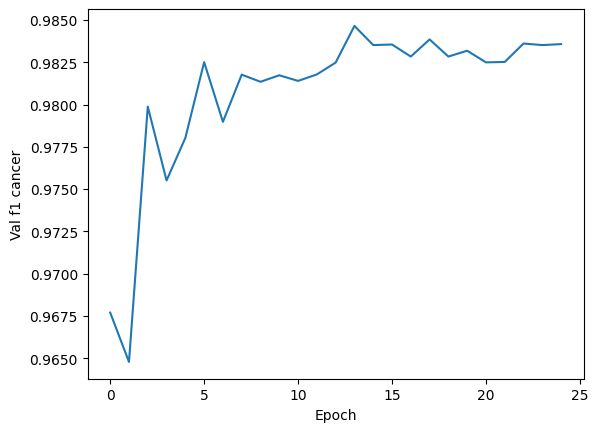

In [18]:
import torch

HIST_PATH  = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_partial_sgd_lr0.01_history.pt"
history_partial = torch.load(HIST_PATH, weights_only=False)

# f.eks. plot val_loss
import matplotlib.pyplot as plt

plt.plot(history_partial["val_f1_cancer"])
plt.xlabel("Epoch")
plt.ylabel("Val f1 cancer")
plt.show()


In [ ]:
# SKIFT NAVN PÅ FIL FOR IKKE AT OVERSKRIVE; HVIS DU SKAL GEMME NY MODEL

#save_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/best_resnet18_pathmnist.pt"
#torch.save(model.state_dict(), save_path)
#print("Saved to:", save_path)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)
import pandas as pd

# =======================================================
# 1) Vælg model + test_loader
# =======================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hvis du stadig har modellen i memory efter træning:
model_test = model_full_high_lr.to(device)   # eller model_full, alt efter hvad du brugte
model_test.eval()

# Hvis du vil loade fra fil i stedet:
# load_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_full_sgd_lr0.01.pt"
# model_test = models.resnet18(weights=None)
# model_test.fc = nn.Linear(model_test.fc.in_features, num_classes)
# model_test.load_state_dict(torch.load(load_path, weights_only=True))
# model_test = model_test.to(device)
# model_test.eval()

# Test-loader (tilpas hvis dit navn er anderledes)
test_loader = data_module.test_loader

# =======================================================
# 2) Loop over test-sættet
# =======================================================

all_labels = []
all_preds  = []
all_probs  = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_test(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

y_true  = np.concatenate(all_labels)        # shape [N]
y_pred  = np.concatenate(all_preds)         # shape [N]
y_score = np.concatenate(all_probs)         # shape [N, n_classes]

# =======================================================
# 3) Globale metrics
# =======================================================

test_acc   = accuracy_score(y_true, y_pred)
test_f1    = f1_score(y_true, y_pred, average="macro")

try:
    test_auc = roc_auc_score(
        y_true, y_score, multi_class="ovr", average="macro"
    )
except ValueError:
    test_auc = float("nan")

# F1 pr. klasse
f1_per_class = f1_score(y_true, y_pred, average=None)

# Find index for cancer-klassen (tilpas navnet hvis nødvendigt)
cancer_name = "colorectal adenocarcinoma epithelium"
cancer_idx = class_names.index(cancer_name)
f1_cancer = f1_per_class[cancer_idx]

print("=== TEST RESULTS ===")
print(f"Test accuracy       : {test_acc:.4f}")
print(f"Test macro F1       : {test_f1:.4f}")
print(f"Test macro AUC (ovr): {test_auc:.4f}")
print(f"Test F1 (cancer)    : {f1_cancer:.4f}  (klasse {cancer_idx}: {cancer_name})")

# =======================================================
# 4) Per-class tabel
# =======================================================

df_per_class = pd.DataFrame({
    "class_idx": list(range(len(class_names))),
    "class_name": class_names,
    "F1": f1_per_class,
})
print("\nPer-class F1:")
print(df_per_class)

# Confusion matrix:
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix shape:", cm.shape)


=== TEST RESULTS ===
Test accuracy       : 0.9035
Test macro F1       : 0.8744
Test macro AUC (ovr): 0.9930
Test F1 (cancer)    : 0.9467  (klasse 8: colorectal adenocarcinoma epithelium)

Per-class F1:
   class_idx                            class_name        F1
0          0                               adipose  0.917628
1          1                            background  0.952756
2          2                                debris  0.826923
3          3                           lymphocytes  0.970769
4          4                                 mucus  0.948757
5          5                         smooth muscle  0.724211
6          6                   normal colon mucosa  0.952761
7          7              cancer-associated stroma  0.629393
8          8  colorectal adenocarcinoma epithelium  0.946741

Confusion matrix shape: (9, 9)


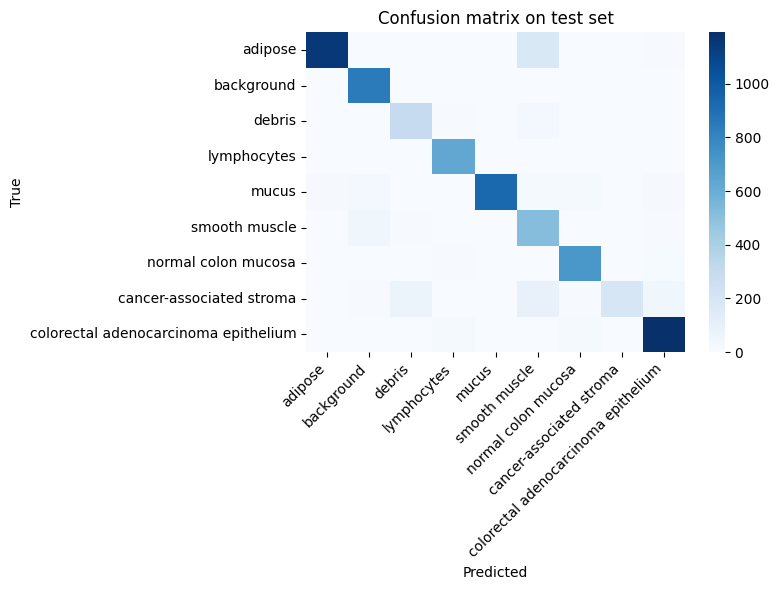

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  # hvis du må bruge seaborn, ellers kan vi lave ren matplotlib

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            fmt="d", ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix on test set")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [22]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)
import pandas as pd

num_classes = len(data_module.class_names)


# =======================================================
# 1) Vælg model + test_loader
# =======================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hvis du stadig har modellen i memory efter træning:
#model_test = model_full.to(device)   # eller model_full, alt efter hvad du brugte
#model_test.eval()

# Hvis du vil loade fra fil i stedet:
load_path = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_full_sgd_lr0.001.pt"
model_test = models.resnet18(weights=None)
model_test.fc = nn.Linear(model_test.fc.in_features, num_classes)
model_test.load_state_dict(torch.load(load_path, weights_only=True))
model_test = model_test.to(device)
model_test.eval()

# Test-loader (tilpas hvis dit navn er anderledes)
test_loader = data_module.test_loader

# =======================================================
# 2) Loop over test-sættet
# =======================================================

all_labels = []
all_preds  = []
all_probs  = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_test(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

y_true  = np.concatenate(all_labels)        # shape [N]
y_pred  = np.concatenate(all_preds)         # shape [N]
y_score = np.concatenate(all_probs)         # shape [N, n_classes]

# =======================================================
# 3) Globale metrics
# =======================================================

test_acc   = accuracy_score(y_true, y_pred)
test_f1    = f1_score(y_true, y_pred, average="macro")

try:
    test_auc = roc_auc_score(
        y_true, y_score, multi_class="ovr", average="macro"
    )
except ValueError:
    test_auc = float("nan")

# F1 pr. klasse
f1_per_class = f1_score(y_true, y_pred, average=None)

# Find index for cancer-klassen (tilpas navnet hvis nødvendigt)
cancer_name = "colorectal adenocarcinoma epithelium"
cancer_idx = class_names.index(cancer_name)
f1_cancer = f1_per_class[cancer_idx]

print("=== TEST RESULTS ===")
print(load_path)
print(f"Test accuracy       : {test_acc:.4f}")
print(f"Test macro F1       : {test_f1:.4f}")
print(f"Test macro AUC (ovr): {test_auc:.4f}")
print(f"Test F1 (cancer)    : {f1_cancer:.4f}  (klasse {cancer_idx}: {cancer_name})")

# =======================================================
# 4) Per-class tabel
# =======================================================

df_per_class = pd.DataFrame({
    "class_idx": list(range(len(class_names))),
    "class_name": class_names,
    "F1": f1_per_class,
})
print("\nPer-class F1:")
print(df_per_class)

# Confusion matrix:
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix shape:", cm.shape)


=== TEST RESULTS ===
/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_full_sgd_lr0.001.pt
Test accuracy       : 0.8928
Test macro F1       : 0.8652
Test macro AUC (ovr): 0.9905
Test F1 (cancer)    : 0.9505  (klasse 8: colorectal adenocarcinoma epithelium)

Per-class F1:
   class_idx                            class_name        F1
0          0                               adipose  0.904630
1          1                            background  0.929238
2          2                                debris  0.856305
3          3                           lymphocytes  0.971384
4          4                                 mucus  0.926501
5          5                         smooth muscle  0.702811
6          6                   normal colon mucosa  0.948287
7          7              cancer-associated stroma  0.597403
8          8  colorectal adenocarcinoma epithelium  0.950479

Confusion matrix shape: (9, 9)


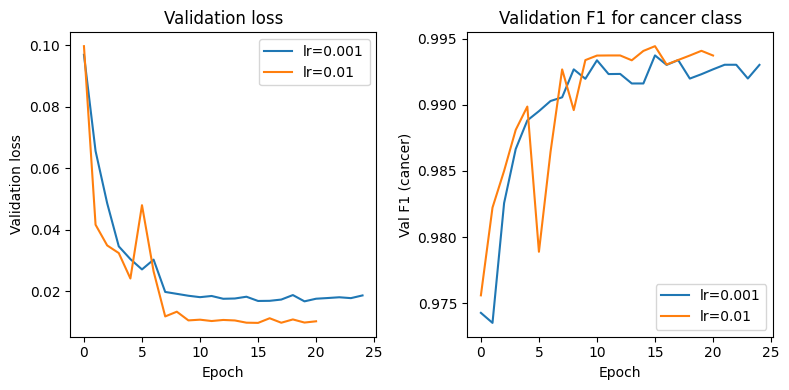

In [20]:
import matplotlib.pyplot as plt
import numpy as np

HIST_PATH_HIGH_LR  = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_full_sgd_high_lr_history.pt"
history_full_high_lr = torch.load(HIST_PATH_HIGH_LR, weights_only=False)

HIST_PATH_LOW_LR  = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_full_sgd_lr0.001_history.pt"
history_full = torch.load(HIST_PATH_LOW_LR, weights_only=False)

epochs_001 = np.arange(len(history_full["val_loss"]))
epochs_010 = np.arange(len(history_full_high_lr["val_loss"]))

plt.figure(figsize=(8,4))

# --- panel 1: val loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs_001, history_full["val_loss"], label="lr=0.001")
plt.plot(epochs_010, history_full_high_lr["val_loss"], label="lr=0.01")
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.title("Validation loss")
plt.legend()

# --- panel 2: val F1 (cancer) ---
plt.subplot(1, 2, 2)
plt.plot(epochs_001, history_full["val_f1_cancer"], label="lr=0.001")
plt.plot(epochs_010, history_full_high_lr["val_f1_cancer"], label="lr=0.01")
plt.xlabel("Epoch")
plt.ylabel("Val F1 (cancer)")
plt.title("Validation F1 for cancer class")
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
print(epochs_001)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


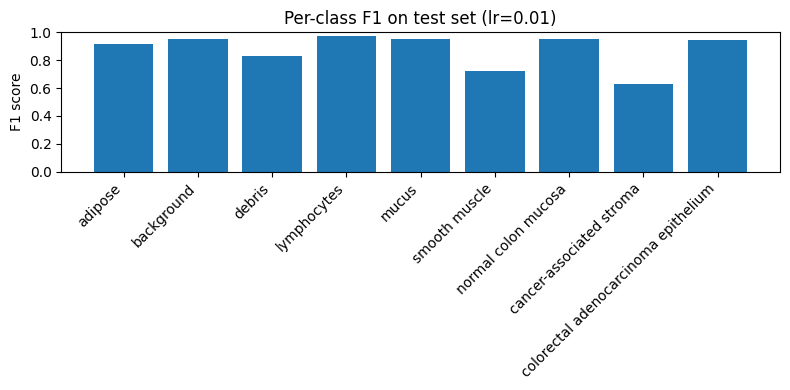

In [25]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------------------------
# 1) Load model weights fra Google Drive
# -------------------------------------------------
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_full_sgd_high_lr.pt"  # <-- indsæt valgt model her

num_classes = len(class_names)          # fra dit data_module

model_test = models.resnet18(weights=None)   # ingen preload, vi loader vores egne weights
model_test.fc = nn.Linear(model_test.fc.in_features, num_classes)

state_dict = torch.load(MODEL_PATH, weights_only=True)
model_test.load_state_dict(state_dict)

model_test = model_test.to(device)
model_test.eval()

# test_loader fra dit data module
test_loader = data_module.test_loader

# -------------------------------------------------
# 2) Kør modellen på test-sættet
# -------------------------------------------------
all_labels = []
all_preds  = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_test(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

y_true = np.concatenate(all_labels)
y_pred = np.concatenate(all_preds)

# -------------------------------------------------
# 3) F1 per klasse + bar-plot
# -------------------------------------------------
f1_per_class = f1_score(y_true, y_pred, average=None)

idx = np.arange(len(class_names))

plt.figure(figsize=(8,4))
plt.bar(idx, f1_per_class)
plt.xticks(idx, class_names, rotation=45, ha="right")
plt.ylim(0.0, 1.0)
plt.ylabel("F1 score")
plt.title("Per-class F1 on test set (lr=0.01)")

plt.tight_layout()
plt.show()


In [3]:
# print fra partial modelen baseret på grid searchen
import torch
import numpy as np

HIST_PATH_PARTIAL = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_partial_sgd_lr0.01_history.pt"

history_partial = torch.load(HIST_PATH_PARTIAL, weights_only=False)

# Antager samme keys som før:
# 'val_loss', 'val_acc', 'val_auc', 'val_f1', 'val_f1_cancer'
val_loss      = history_partial["val_loss"]
val_acc       = history_partial["val_acc"]
val_auc       = history_partial["val_auc"]
val_f1        = history_partial["val_f1"]
val_f1_cancer = history_partial.get("val_f1_cancer", None)

# find bedste epoch ift. val_f1 (eller val_f1_cancer hvis du hellere vil det)
best_epoch_macro = int(np.argmax(val_f1))
best_epoch_cancer = int(np.argmax(val_f1_cancer)) if val_f1_cancer is not None else None

print("=== Best (macro F1) ===")
print(f"Epoch          : {best_epoch_macro}")
print(f"Val loss       : {val_loss[best_epoch_macro]:.4f}")
print(f"Val acc        : {val_acc[best_epoch_macro]:.4f}")
print(f"Val AUC (ovr)  : {val_auc[best_epoch_macro]:.4f}")
print(f"Val macro F1   : {val_f1[best_epoch_macro]:.4f}")
if val_f1_cancer is not None:
    print(f"Val F1 (cancer): {val_f1_cancer[best_epoch_macro]:.4f}")

if best_epoch_cancer is not None:
    print("\n=== Best (F1 for cancer class) ===")
    print(f"Epoch          : {best_epoch_cancer}")
    print(f"Val loss       : {val_loss[best_epoch_cancer]:.4f}")
    print(f"Val acc        : {val_acc[best_epoch_cancer]:.4f}")
    print(f"Val AUC (ovr)  : {val_auc[best_epoch_cancer]:.4f}")
    print(f"Val macro F1   : {val_f1[best_epoch_cancer]:.4f}")
    print(f"Val F1 (cancer): {val_f1_cancer[best_epoch_cancer]:.4f}")


=== Best (macro F1) ===
Epoch          : 19
Val loss       : 0.0371
Val acc        : 0.9885
Val AUC (ovr)  : 0.9998
Val macro F1   : 0.9886
Val F1 (cancer): 0.9832

=== Best (F1 for cancer class) ===
Epoch          : 13
Val loss       : 0.0382
Val acc        : 0.9881
Val AUC (ovr)  : 0.9998
Val macro F1   : 0.9881
Val F1 (cancer): 0.9846


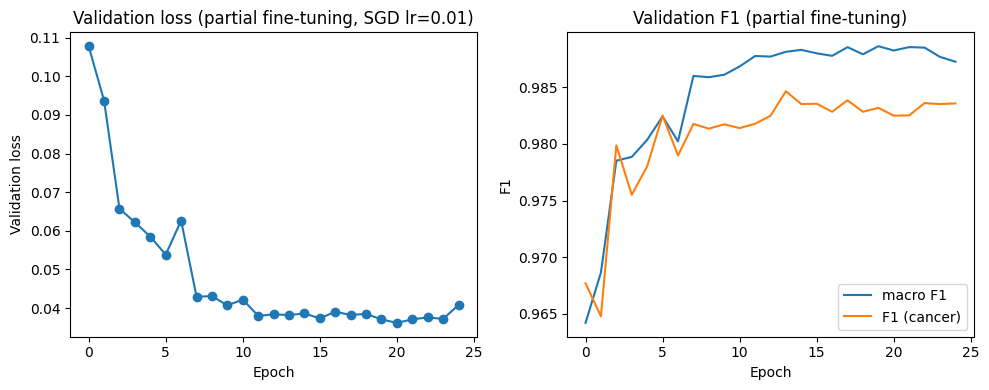

In [5]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(len(history_partial["val_loss"]))

plt.figure(figsize=(10,4))

# Panel 1: val loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history_partial["val_loss"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.title("Validation loss (partial fine-tuning, SGD lr=0.01)")

# Panel 2: val F1 (macro eller cancer)
plt.subplot(1, 2, 2)
plt.plot(epochs, history_partial["val_f1"], label="macro F1")
if "val_f1_cancer" in history_partial:
    plt.plot(epochs, history_partial["val_f1_cancer"], label="F1 (cancer)")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.title("Validation F1 (partial fine-tuning)")
plt.legend()

plt.tight_layout()
plt.show()


Full lr=0.001 best epoch: 16 F1: 0.9937238493723849
Full lr=0.01  best epoch: 16 F1: 0.9944211994421199
Partial lr=0.01 best epoch: 14 F1: 0.9846475924633635


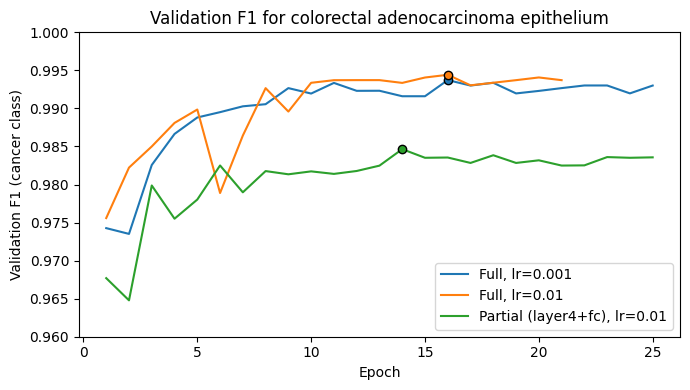

In [6]:
# plot F1 for alle tre modeller og vis punktet hvor modellen gemmes

import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Load histories ---
HIST_FULL_LR001 = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_full_sgd_lr0.001_history.pt"
HIST_FULL_LR01  = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_full_sgd_high_lr_history.pt"
HIST_PARTIAL    = "/content/drive/MyDrive/Colab Notebooks/saved_models/pathmnist_resnet18_partial_sgd_lr0.01_history.pt"

history_full_lr001 = torch.load(HIST_FULL_LR001, weights_only=False)
history_full_lr01  = torch.load(HIST_FULL_LR01,  weights_only=False)
history_partial    = torch.load(HIST_PARTIAL,    weights_only=False)

# --- 2) Extract F1(cancer) curves ---
f1_full_lr001 = np.array(history_full_lr001["val_f1_cancer"])
f1_full_lr01  = np.array(history_full_lr01["val_f1_cancer"])
f1_partial    = np.array(history_partial["val_f1_cancer"])

epochs_full_lr001 = np.arange(1, len(f1_full_lr001) + 1)  # 1..N
epochs_full_lr01  = np.arange(1, len(f1_full_lr01)  + 1)
epochs_partial    = np.arange(1, len(f1_partial)    + 1)

# --- 3) Find bedste epoch for hver kurve ---
best_idx_lr001 = np.argmax(f1_full_lr001)
best_idx_lr01  = np.argmax(f1_full_lr01)
best_idx_part  = np.argmax(f1_partial)

best_ep_lr001 = epochs_full_lr001[best_idx_lr001]
best_ep_lr01  = epochs_full_lr01[best_idx_lr01]
best_ep_part  = epochs_partial[best_idx_part]

best_f1_lr001 = f1_full_lr001[best_idx_lr001]
best_f1_lr01  = f1_full_lr01[best_idx_lr01]
best_f1_part  = f1_partial[best_idx_part]

print("Full lr=0.001 best epoch:", best_ep_lr001, "F1:", best_f1_lr001)
print("Full lr=0.01  best epoch:", best_ep_lr01,  "F1:", best_f1_lr01)
print("Partial lr=0.01 best epoch:", best_ep_part, "F1:", best_f1_part)

# --- 4) Plot alle tre kurver + markér bedste epoch ---
plt.figure(figsize=(7,4))

line1, = plt.plot(epochs_full_lr001, f1_full_lr001, label="Full, lr=0.001")
line2, = plt.plot(epochs_full_lr01,  f1_full_lr01,  label="Full, lr=0.01")
line3, = plt.plot(epochs_partial,    f1_partial,    label="Partial (layer4+fc), lr=0.01")

# Brug samme farve som linjerne til markørerne
plt.scatter(best_ep_lr001, best_f1_lr001, marker="o", edgecolor="black", zorder=5)
plt.scatter(best_ep_lr01,  best_f1_lr01,  marker="o", edgecolor="black", zorder=5)
plt.scatter(best_ep_part,  best_f1_part,  marker="o", edgecolor="black", zorder=5)

plt.xlabel("Epoch")
plt.ylabel("Validation F1 (cancer class)")
plt.title("Validation F1 for colorectal adenocarcinoma epithelium")
plt.ylim(0.96, 1.0)
plt.legend()

plt.tight_layout()

os.makedirs("Pictures", exist_ok=True)
plt.savefig("Pictures/val_f1_cancer_three_models.png", dpi=300, bbox_inches="tight")
plt.show()
